# Visual Odometry Grundlagen

In [38]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
img_id = 100
img_path1 = 'C:\\Users\\stern\\Desktop\\data_odometry_gray\\dataset\\sequences\\00\\image_0\\'+str(img_id).zfill(6)+'.png'
img_path1 = '../../data/recordings/series28/0050.png'
img1 = cv2.imread(img_path1)

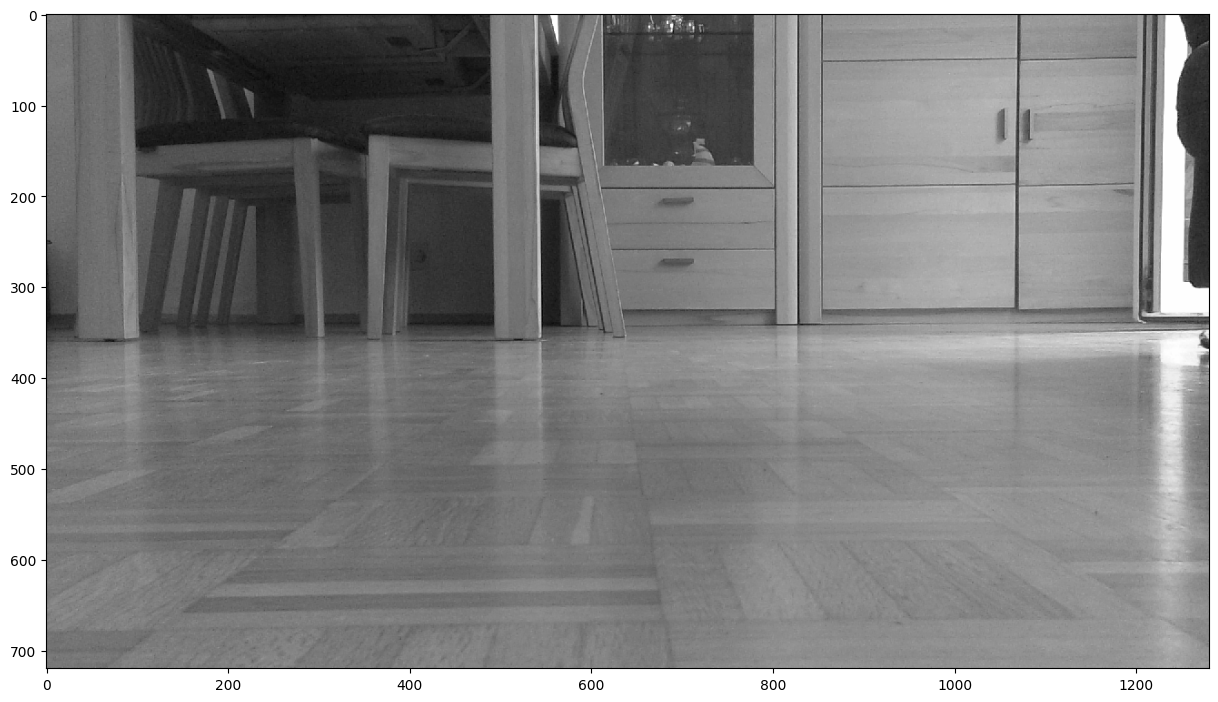

In [3]:
plt.figure(figsize=(15, 15))
plt.imshow(img1)

## Feature Detection

Visual Odometry arbeitet mit Points of Interest innerhalb des Bildes. Das sind z.B. starke Kanten in den Farben.  
Diese Features müssen erst einmal gefunden werden. Dafür gibt es zum Glück (wie bei allen klassischen Computer Vision Tasks) eine OpenCV-Funktion.

Ein Problem, auf das ich hinweisen will, ist, dass VO wegen der kleineren Anzahl an klaren Features in Innenbereichen deutlich schlechter funktioniert, als in Außenbereichen. Der Threshhold beim Featuredetektor muss auf kleinere Werte gesetzt werden und führt dazu, dass auch schlechte Features erkannt werden, die in den nachfolgenden Schritten Fehler verursachen

In [4]:
feature_detector = cv2.FastFeatureDetector_create(threshold=22, nonmaxSuppression=True)

In [5]:
points_ref = feature_detector.detect(img1)
pts_ref = feature_detector.detect(img1)
points_ref = np.array([point.pt for point in points_ref], dtype = 'float32')

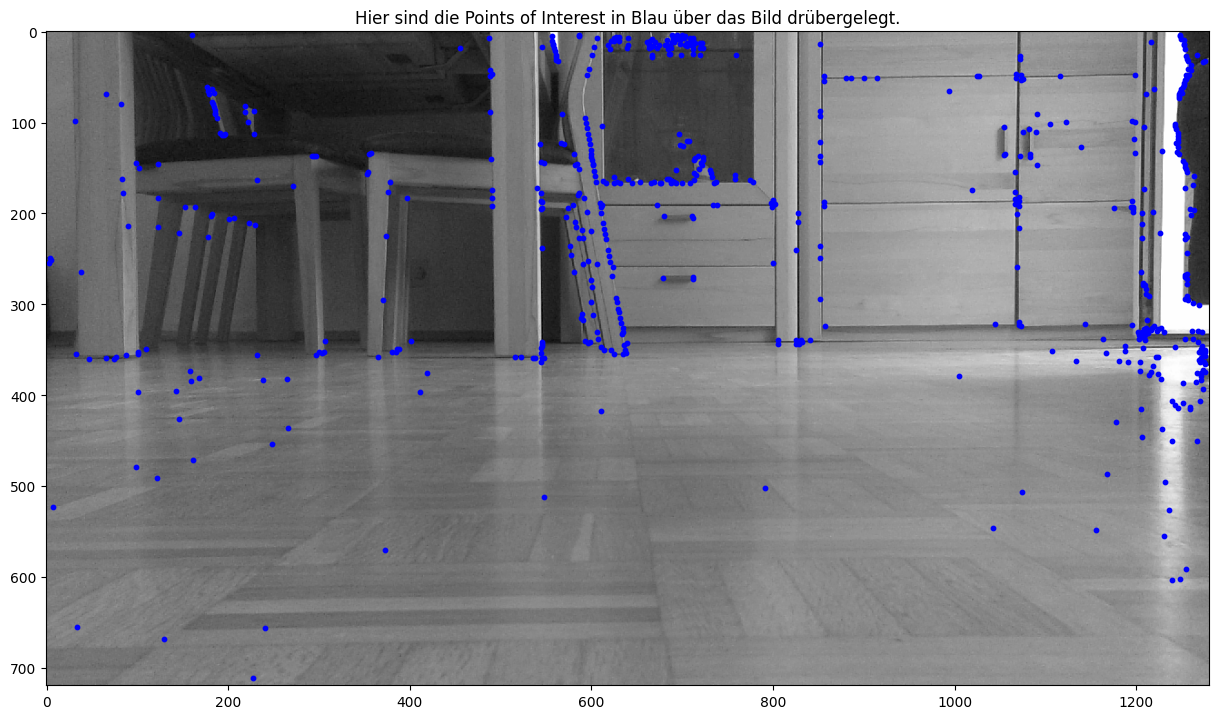

In [21]:
plt.figure(figsize=(15, 15))
plt.scatter(points_ref[:,0],points_ref[:,1],  s=10, c='blue' )
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Hier sind die Points of Interest in Blau über das Bild drübergelegt.')
plt.show()

Um die Veränderng in der Position richtig zu bestimmen, müssen aufeinanderfolgende Frames miteinander verglichen werden. Wir laden jetzt also den nächsten Frame. Wichtig! Hier werden nicht noch einmal neue Features berechnet.

In [7]:
img_path2 = 'C:\\Users\\stern\\Desktop\\data_odometry_gray\\dataset\\sequences\\00\\image_0\\'+str(img_id+1).zfill(6)+'.png'
img_path2 = '../../data/recordings/series28/0063.png'
img2 = cv2.imread(img_path2)

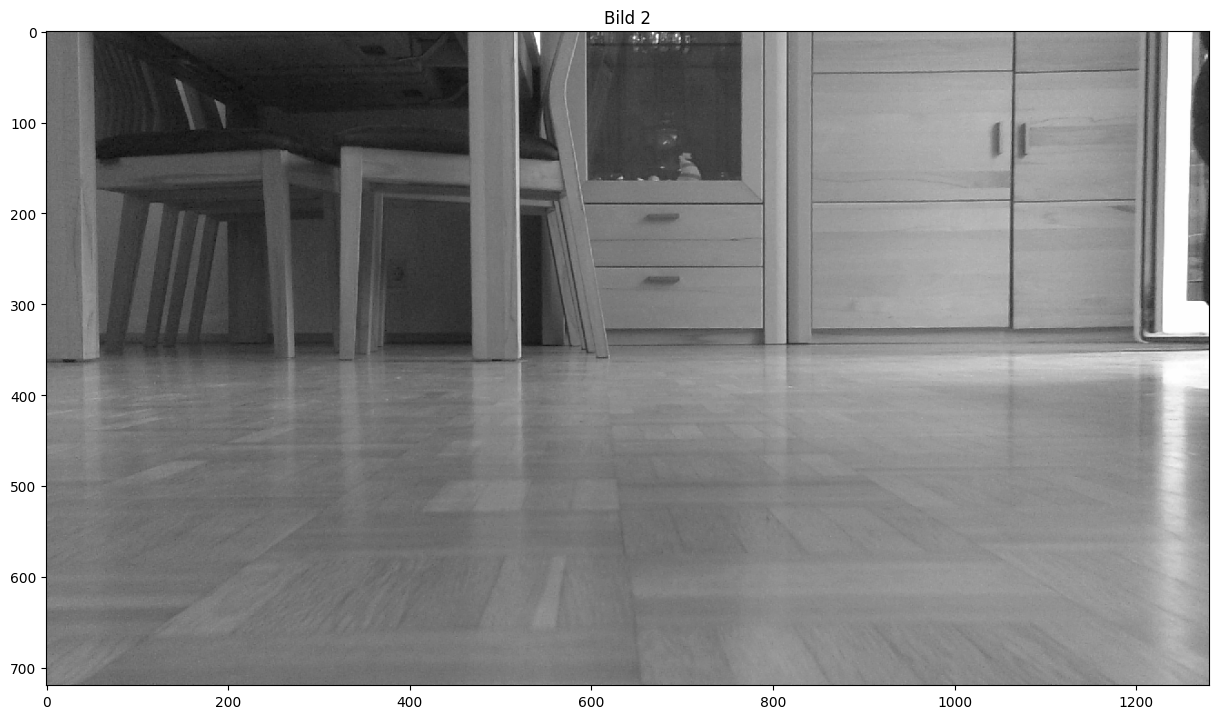

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Bild 2')
plt.show()

# Feature Tracking

Um die Veränderung zwischen den Frames festzustellen, müssen wir herausfinden, welche Points of Interest in beiden Bildern vorhanden sind. Dafür nutzen wir den Lukas Kanade Algorithmus. Der versucht die detektierten Feature Points aus Bild 1 in Bild2 wiederzufinden. Dabei macht er einige Annahmen, auf die hier nicht näher eingegangen werden muss. Auch die Parametrisierung ist etwas umfangreicher.  

Als Output erhält man die neue Position der alten Keypoints, eine Boolmaske, in der gespeichert wird, welche Keypoints wiedergefunden wurden und ein array mit error Werten (Wie stark unterscheiden sich die Pixel im Umkreis des neuen Keypoints von denen des alten). Letzteres nutzen wir hier nicht weiter.

In [9]:
lk_params = dict(winSize  = (21, 21), 
				#maxLevel = 3,
             	criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

keypoints2, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, points_ref, None, **lk_params)  #shape: [k,2] [k,1] [k,1]
st = st.reshape(st.shape[0])
points_ref_filtered = points_ref[st == 1]

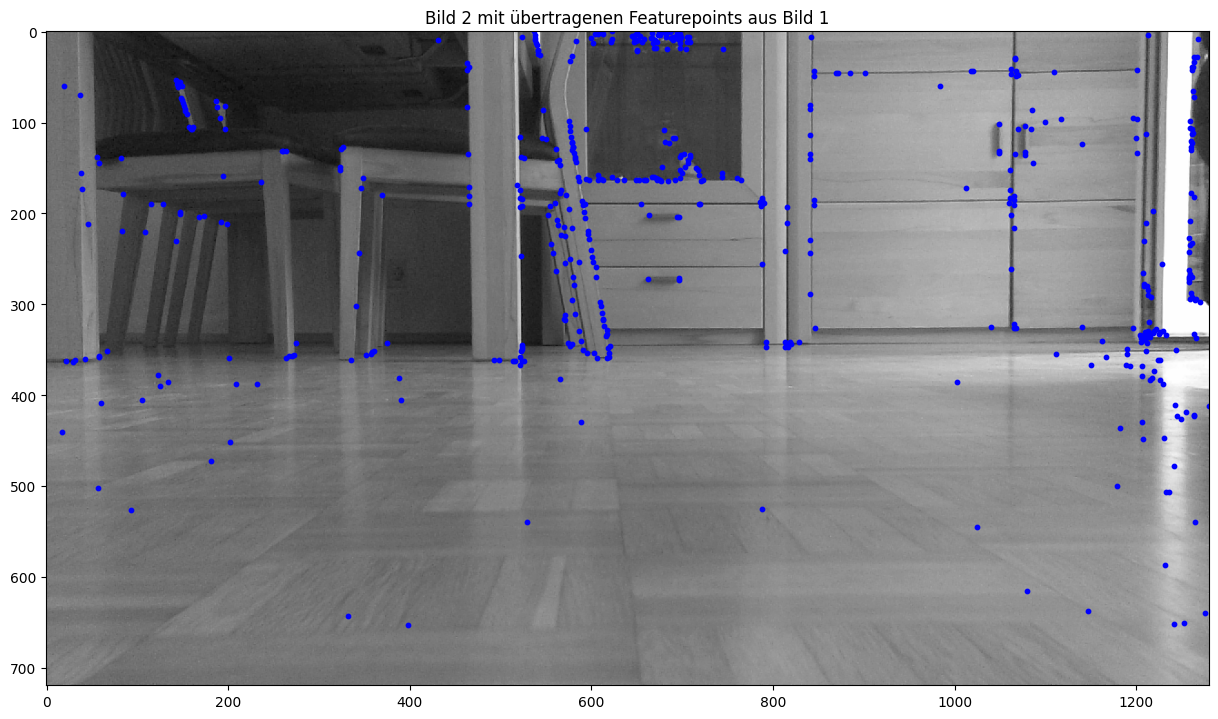

In [10]:
plt.figure(figsize=(15,15))
plt.scatter(keypoints2[:,0],keypoints2[:,1],  s=10, c='blue' )
plt.imshow(img2)
plt.title('Bild 2 mit übertragenen Featurepoints aus Bild 1')
plt.show()

Die hier in blau dargestellten Keypoints sind alle auf Bild 1 berechnet und dann nur mit dem LK-Algorithmus auf Bild 2 Übertragen worden.  
Der Optical Flow (Bildverschiebung) kann jetzt durch die Veränderung der Position der Keypoints berechnet werden.

In [11]:
# Parameter
lk_params = dict(winSize=(21, 21),
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
pts_ref = feature_detector.detect(img1)
pts_ref = np.array([x.pt for x in pts_ref], dtype = 'float32')
print(pts_ref.shape)

keypoints2, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, pts_ref, None, **lk_params)


(630, 2)


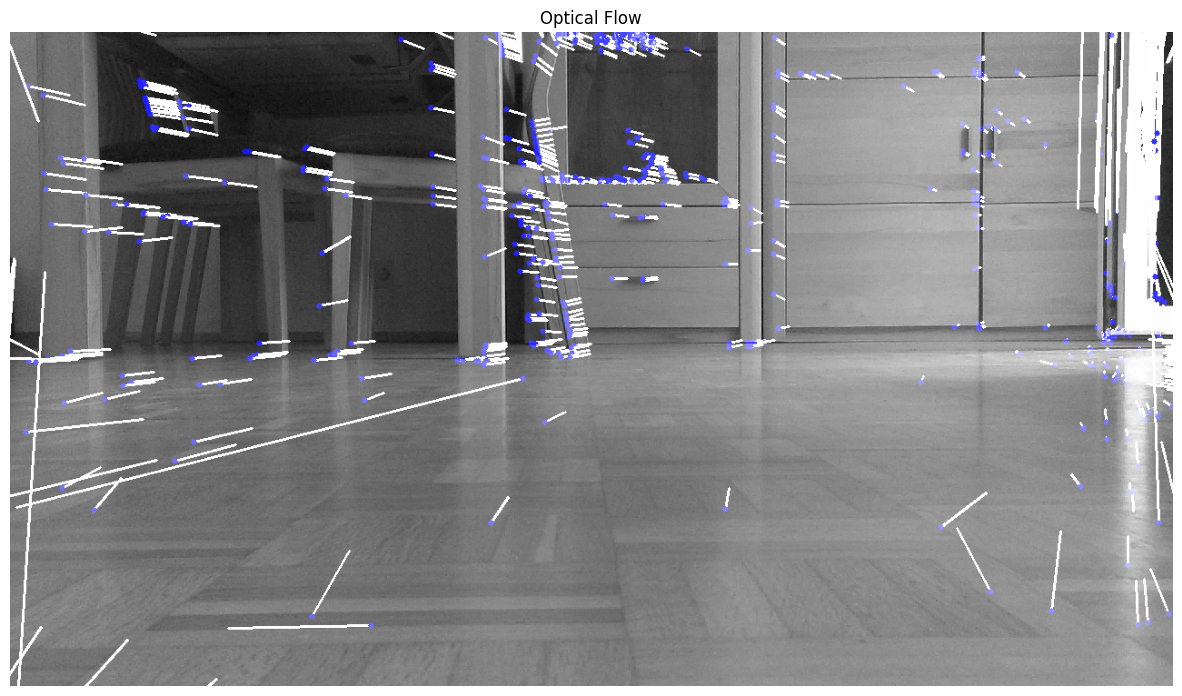

In [20]:

mask = np.zeros_like(img1)

# draw the optical flow vectors on the mask image
for i, (new, old) in enumerate(zip(keypoints2, points_ref)):
    a, b = new.ravel()
    c, d = old.ravel()
    a, b, c, d = int(a), int(b), int(c), int(d)  # ensure coordinates are integers
    mask = cv2.line(mask, (a, b), (c, d), (255, 255, 255), 2)
    mask = cv2.circle(mask, (a, b), 3, (0, 0, 255), -1)

output_img = cv2.add(img1, mask)


plt.figure(figsize=(15, 15))
plt.imshow(output_img, cmap='gray')
plt.title('Optical Flow')
plt.axis('off') 
plt.show()

### Wie wird daraus ein Positionsupdate?

In [35]:
E, mask = cv2.findEssentialMat(keypoints2, points_ref, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, mask = cv2.recoverPose(E,  keypoints2, points_ref)

In [39]:
R

array([[ 1.    ,  0.0019,  0.    ],
       [-0.0019,  1.    , -0.    ],
       [-0.    ,  0.    ,  1.    ]])

Die Rotationsmatrix R beschreibt die stattgefundene Rotation zwischen den Frames. Aus dieser kann man z.B. Yaw extrahieren.

In [40]:
t

array([[0.9702],
       [0.2424],
       [0.0008]])

Der t-Vektor ist der Translationsvektor. Der sagt aus, in welche Richtung die Kamera zwischen den Bildern bewegt wurde.

**Anmerkung**
Normalerweise gibt man den cv2-Funktionen findEssentialMat und recoverPose noch Informationen über die eigene Kamera mit (z.B. Brennweite). Das habe ich hier ausgelassen.